<h2 style="font-size: 24px;">Trabajo Final</h2>
<p>
    Casos de Estudios Aplicados al Sector Seguros y Financieros en Colombia<br>
    Maestría en Analítica y Gerencia de Datos II<br>
    <i>Yessica Paola García Alvarado</i>
</p>

Carga de todas las librerías que se usarán en el trabajo

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Importar archivos o módulos
import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
import scipy.stats as ss
from collections import deque
from funciones_apoyo import *
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Carga del archivo 'AGUA_V2_40.parquet' desde la carpeta 'src'
file_path = os.path.join(os.path.abspath('../src'), 'AGUA_V2_40.parquet')
df = pd.read_parquet(file_path) 

In [355]:
#Lectura del diccionario
dict_path=r'../src/data_dict.xlsx'
dict = pd.read_excel(dict_path)

In [356]:
# Información general del DataFrame 'AGUA_V2_40.parquet'
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371390 entries, 0 to 371389
Columns: 681 entries, AGRUPAGENTE to zonas_verdes_urbanas
dtypes: float64(659), int32(1), object(21)
memory usage: 1.9+ GB
None


In [357]:
# Reducir el tamaño del DataFrame para el análisis
random.seed(42)
df= df.sample(n=len(df))

In [358]:
# Se define las variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

In [359]:
# Filtrar el DataFrame 'df' para que solo incluya las filas donde la columna especificada por 'peso' tiene valores mayores a 0.
# Esto elimina filas con valores de 'peso' igual a 0 o negativos.
df=df[df[peso]>0]

In [ ]:
# Crear una nueva columna 'resp', que representa la división de la columna  'var_resp' entre la columna 'peso'. 
df['resp']=df[var_resp]/df[peso]

Procesamiento de datos

In [361]:
# Se carga un excel con las variables del df y una columna de acciones, alli se establece que se debe colocar en caso de encontrar un NaN, 
dict_path1=r'../src/acciones.xlsx'
acciones_df = pd.read_excel(dict_path1)

In [ ]:
# Reemplazar valores nulos en la columna 'antigref' con los valores de la columna 'antigedif'
# Verificar la cantidad de valores nulos restantes en 'antigref' después del reemplazo
df['antigref'] = df['antigref'].fillna(df['antigedif'])
print("NaN en antigref después del reemplazo:", df['antigref'].isnull().sum())

NaN en antigref después del reemplazo: 0


Se realizan las siguientes gráficas para visualizar el comportamiento de estas 3 variables 'antigedif' 'antigref' 'ANTIGUEDAD_VIVIENDA', 

'antigedif'
La antigüedad del edificio puede ser un indicador clave del desgaste y deterioro de las instalaciones hidráulicas, como tuberías, válvulas y sistemas de drenaje. Con el tiempo, los materiales de construcción se deterioran, aumentando la probabilidad de fugas o averías relacionadas con el agua.
Un edificio más antiguo puede tener mayor riesgo debido a la falta de mantenimiento o a que los sistemas de agua no se han actualizado.
Esta variable podría tener una relación no lineal con el riesgo (por ejemplo, el riesgo aumenta hasta cierto punto y luego se estabiliza), lo que puede modelarse bien con el modelo de GLM.

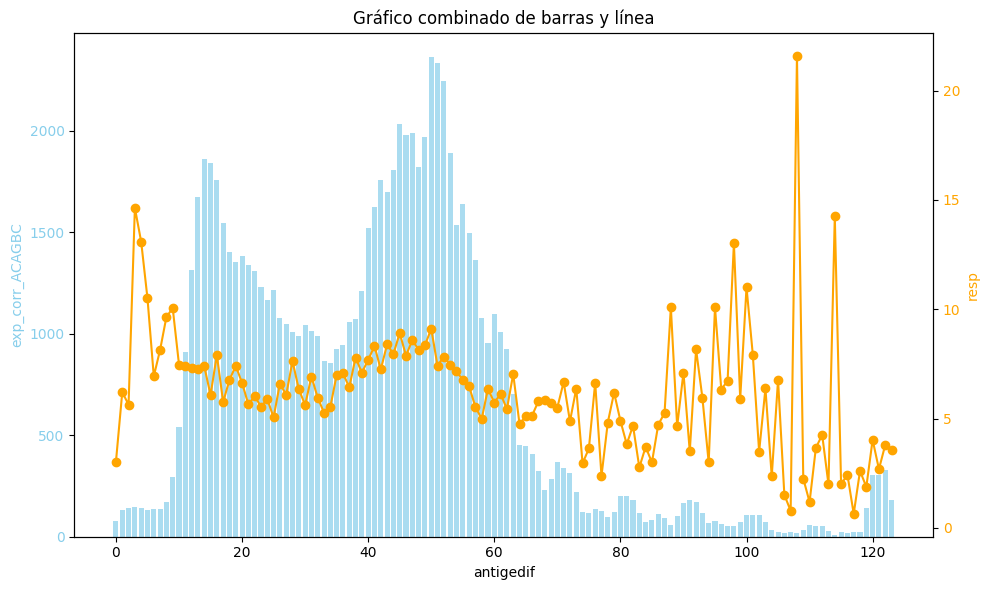

In [ ]:
# Definir la variable de interés ('antigedif')
# Verificar el tipo de dato de la columna seleccionada
# Agrupar los datos por la variable seleccionada y calcular la suma de 'peso' y el promedio de 'resp'
# Graficar los resultados agrupados utilizando un gráfico de barras y línea
var='antigedif'
df[var].dtype
df_resumido = df.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

'antigref'
Representa el tiempo transcurrido desde la última reforma o renovación significativa en el edificio o en la vivienda. Las reformas pueden incluir cambios o actualizaciones en sistemas hidráulicos, que tienen un impacto directo en la reducción de riesgos de averías relacionadas con el agua.
A mayor antigüedad de la reforma, es probable que los materiales y sistemas actualizados hayan comenzado a desgastarse nuevamente.
Complementa a la variable antigedif al agregar una dimensión relacionada con el mantenimiento y las actualizaciones.
Captura el impacto de las inversiones en reformas para mitigar riesgos.
Es una variable clave para analizar cómo el tiempo desde la última reforma afecta la probabilidad de un siniestro.

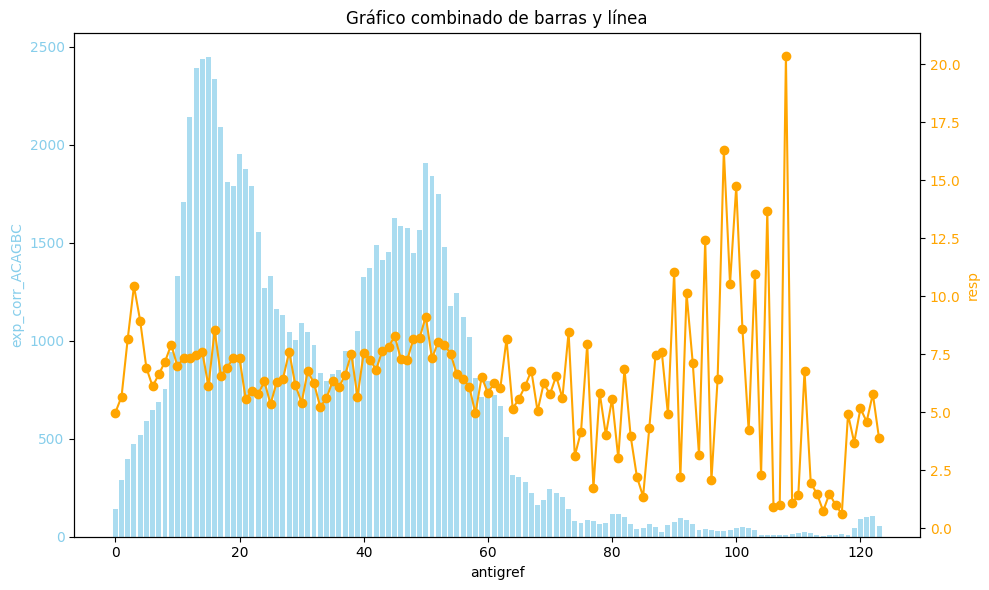

In [ ]:
# Definir la variable de interés ('antigref')
# Verificar el tipo de dato de la columna seleccionada
# Agrupar los datos por la variable seleccionada y calcular la suma de 'peso' y el promedio de 'resp'
# Graficar los resultados agrupados utilizando un gráfico de barras y línea
var='antigref'
df[var].dtype
df_resumido = df.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

'ANTIGUEDAD_VIVIENDA'
La antigüedad de la vivienda puede capturar características específicas del hogar dentro del conjunto residencial, como el estado de los grifos, lavamanos, calentadores de agua y sistemas internos de plomería. Las viviendas más antiguas dentro de un edificio pueden estar más propensas a fugas internas, especialmente si han tenido un mantenimiento deficiente.
Complementa la información sobre la antigüedad del edificio (antigedif) al centrarse en aspectos individuales de las unidades residenciales.
Puede servir para identificar patrones específicos dentro de un conjunto de viviendas, como diferencias entre casas nuevas y casas más antiguas.

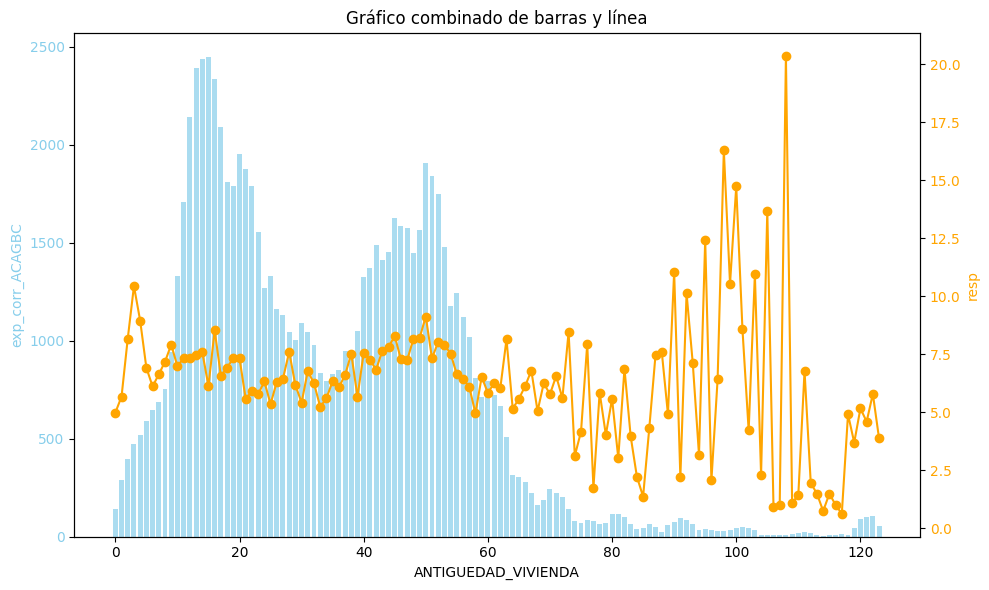

In [ ]:
# Definir la variable de interés ('ANTIGUEDAD_VIVIENDA')
# Verificar el tipo de dato de la columna seleccionada
# Agrupar los datos por la variable seleccionada y calcular la suma de 'peso' y el promedio de 'resp'
# Graficar los resultados agrupados utilizando un gráfico de barras y línea
var='ANTIGUEDAD_VIVIENDA'
df[var].dtype
df_resumido = df.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

Se realiza un ajuste a las variables para poder colocarlas en el modelo GLM

In [ ]:
# Generar una versión corregida de la columna 'antigedif' con un formato homogéneo utilizando una función específica.
antig_corregida=generar_formato_exposicion_homogenea(df, 'antigedif', peso, 10)
# Crear una nueva columna 'antigedif_2' que contiene los valores corregidos de 'antigedif'.
df['antigedif_2'] = antig_corregida  # Sobrescribimos la columna corregida
# Reemplazar valores no válidos ('nan') con valores NaN reales y calcular la moda de la columna para imputación.
df['antigedif_2'].replace('nan',np.nan).mode(dropna=True)[0] 
moda = df['antigedif_2'].mode(dropna=True)[0] # Identificar la moda excluyendo valores nulos
# Imputar los valores faltantes en 'antigedif_2' utilizando la moda calculada.
df['antigedif_2'] = df['antigedif_2'].fillna(moda)
# Eliminar la columna original 'antigedif', ya que ahora usamos la columna corregida 'antigedif_2'.
df = df.drop(columns=['antigedif'], errors='ignore')

In [ ]:
# Generar los valores corregidos para la columna 'antigref' utilizando una función específica que aplica un formato homogéneo basado en el peso y otros criterios.
reforma_corregida = generar_formato_exposicion_homogenea(df, 'antigref', peso, 10)
# Crear una nueva columna 'antigref_2' y asignarle los valores corregidos. Esto se hace para conservar una versión modificada de la variable original.
df['antigref_2'] = reforma_corregida
# Calcular la moda de la columna 'antigref_2', ignorando los valores nulos, para usarla como valor de imputación para los valores faltantes.
moda = df['antigref_2'].mode(dropna=True)[0]
# Reemplazar los valores nulos (NaN) en 'antigref_2' con la moda calculada.
df['antigref_2'] = df['antigref_2'].fillna(moda)
# Eliminar la columna original 'antigref', ya que su versión corregida ('antigref_2') será la utilizada. El argumento 'errors="ignore"' asegura que no habrá errores si la columna ya no existe.
df = df.drop(columns=['antigref'], errors='ignore')

In [ ]:
# Generar una versión corregida de la columna 'ANTIGUEDAD_VIVIENDA' utilizando un formato homogéneo. Esto asegura que los datos estén estandarizados y sean consistentes para su análisis.
vivienda_corregida = generar_formato_exposicion_homogenea(df, 'ANTIGUEDAD_VIVIENDA', peso, 10)
# Crear una nueva columna 'ANTIGUEDAD_VIVIENDA_2' con los valores corregidos generados. Esto permite conservar la versión original de los datos mientras se trabaja con la corregida.
df['ANTIGUEDAD_VIVIENDA_2'] = vivienda_corregida
# Calcular la moda de la nueva columna 'ANTIGUEDAD_VIVIENDA_2', excluyendo valores nulos (NaN). La moda representa el valor más frecuente y se utilizará para imputar valores faltantes.
moda = df['ANTIGUEDAD_VIVIENDA_2'].mode(dropna=True)[0]
# Reemplazar los valores nulos (NaN) en 'ANTIGUEDAD_VIVIENDA_2' con la moda calculada. Esto asegura que no haya valores faltantes en la columna corregida.
df['ANTIGUEDAD_VIVIENDA_2'] = df['ANTIGUEDAD_VIVIENDA_2'].fillna(moda)
# Eliminar la columna original 'ANTIGUEDAD_VIVIENDA' para evitar redundancia y asegurar que se trabaje únicamente con la columna corregida.
df = df.drop(columns=['ANTIGUEDAD_VIVIENDA'], errors='ignore')

Se realiza modificación en la categoría de estas dos variables

In [ ]:
# Convertir la columna 'CODPOST' a un formato numérico, reemplazando valores no válidos por NaN.
df['CODPOST'] = pd.to_numeric(df['CODPOST'], errors='coerce')
# Reemplazar valores NaN en 'CODPOST' con un valor predeterminado (en este caso, 0).
# Esto asegura que la columna no tenga valores faltantes y sea manejable en análisis posteriores.
df['CODPOST'].fillna(0, inplace=True)
# Convertir la columna 'CODPOST' a tipo entero (int), ya que los valores ahora son válidos y no hay NaN.
df['CODPOST'] = df['CODPOST'].astype(int)
# Repetir el mismo proceso para la columna 'CODINE':
# 1. Convertir a numérico y manejar valores no válidos con NaN.
df['CODINE'] = pd.to_numeric(df['CODINE'], errors='coerce')
# 2. Reemplazar valores NaN en 'CODINE' con 0 para eliminar valores faltantes.
df['CODINE'].fillna(0, inplace=True)
# 3. Convertir la columna 'CODINE' a tipo entero (int).
df['CODINE'] = df['CODINE'].astype(int)

Se toma la decisión de borrar las variables, ya que generan ruido por la cantidad de datos que tiene

In [ ]:
# Eliminar la columna 'CODINE' del DataFrame si existe.
df = df.drop(columns=['CODINE'], errors='ignore')
# Eliminar la columna 'CODPOST' del DataFrame si existe.
df = df.drop(columns=['CODPOST'], errors='ignore')

Para continuar con el tratamiento de los datos, se aplica la función de acciones para reemplazar NaN, allí coge la bd en excel que le pasamos, recorre el dataframe completo y va aplicando las acciones 'quitar', 'colocar 0', 'colocar la moda' y en la variable antigref los NaN igualar a los valores de la variable antigedif

In [ ]:
#Aplicar acciones
df = aplicar_acciones(df, acciones_df)
# Verificar los resultados
print(df.isna().sum())  # Mostrar los NaN restantes por columna

Advertencia: La columna 'antigref' no se encuentra en el DataFrame.
Advertencia: La columna 'antigedif' no se encuentra en el DataFrame.
Advertencia: La columna 'ANTIGUEDAD_VIVIENDA' no se encuentra en el DataFrame.
Advertencia: La columna 'CODINE' no se encuentra en el DataFrame.
AGRUPAGENTE                         0
Altitud                             0
anualidad_reemplazo                 0
anualidad_seguro                    0
AnyoCons_edif                       0
AnyoCons_edif_total                 0
AUX                                 0
bloqueo                             0
CANAL                               0
catage_emp                          0
catage_glob                         0
catage_hog                          0
catage_tur                          0
CATTAG                              0
cl_cobro                            0
CODPROV                             0
COMESP                              0
CONFCOMELE                          0
Contr_Agr_pct                     

In [ ]:
#Esta función ayuda a verificar que no exista ningun NaN en la base de datos.
print (generar_resumen_nan(df))

                             Variable  Porcentaje de NaN Tipo de Dato  \
676             ANTIGUEDAD_VIVIENDA_2                0.0     category   
0                         AGRUPAGENTE                0.0      float64   
1                             Altitud                0.0      float64   
2                 anualidad_reemplazo                0.0      float64   
3                    anualidad_seguro                0.0      float64   
660                    widower_high64                0.0      float64   
659                     widower_16_64                0.0      float64   
658                           widower                0.0      float64   
657                  viv_super_mas180                0.0      float64   
656                  viv_super_91_105                0.0      float64   
655                   viv_super_76_90                0.0      float64   
654                   viv_super_61_75                0.0      float64   
653                   viv_super_46_60              

Mirar variables significantes

In [ ]:
# Crear el conjunto de variables predictoras (X) excluyendo la columna 'resp' del DataFrame original.
# 'resp' es la variable respuesta, por lo que se elimina de X para evitar fugas de datos en el modelo.
X = df.drop('resp', axis=1)  # Excluye la variable respuesta
# Asignar la columna 'resp' como variable respuesta (y), ya que es el objetivo a predecir en el modelo.
y = df['resp']  # Variable respuesta
# Eliminar columnas adicionales que no se usarán como predictoras en X.
# Esto asegura que 'var_resp' y 'peso' no se incluyan en el conjunto de predictores.
X = X.drop(columns=[var_resp, peso], errors='ignore')

Se corre el modelo Random Forest por:

Eficiencia: Automatiza la selección de las variables más relevantes, ahorrando tiempo en análisis exploratorio manual.

Flexibilidad: Captura relaciones no lineales y robustas, incluso frente a multicolinealidad.

Precisión: Reduce el riesgo de incluir variables no significativas o ruidosas, mejorando el desempeño del modelo final.

Interpretabilidad: Proporciona una métrica clara de la importancia de las variables, facilitando la comunicación de resultados.

**Este código tarda al rededor de 10 min en arrojar el resultado.**

In [ ]:
# Convertir las variables categóricas en variables dummies (indicadoras) para incluirlas en el modelo.
# La opción 'drop_first=True' elimina una categoría por cada variable para evitar colinealidad.
X1=pd.get_dummies(X, drop_first=True)
# Crear un modelo de Random Forest Regressor para evaluar la importancia de las variables.
# Se define un número de 100 estimadores (árboles), un estado aleatorio para reproducibilidad (42),
# y el uso de todos los núcleos disponibles (-1) para mejorar el rendimiento.
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Entrenar el modelo de Random Forest con las variables predictoras (X1) y la variable respuesta (y).
rf.fit(X1, y)

# Extraer la importancia de las variables a partir del modelo Random Forest entrenado.
# La importancia de cada variable refleja su contribución relativa a las predicciones.
importance = rf.feature_importances_
# Filtrar las variables cuya importancia sea mayor al umbral establecido (0.0005 o 0.05%).
# Este umbral asegura que solo se seleccionen las variables más relevantes.
selected_features = X1.columns[importance > 0.0005]  # Filtrar variables con importancia > 0.05%
# Imprimir las variables seleccionadas por el modelo Random Forest basándose en su importancia.c
print("Variables seleccionadas por Random Forest:")
print(selected_features)

Variables seleccionadas por Random Forest:
Index(['CUPD_CAP_Corr_aguaacagbc', 'EXPOSICION', 'K_ACAGBC'], dtype='object')


Se escogen las variables que tendrá el modelo

In [ ]:
# Crear una lista de las variables seleccionadas por Random Forest (selected_features)
# y agregar manualmente otras variables relevantes para el modelo (antigedif_2, antigref_2, etc.).
variables_to_include = list(selected_features) + ['antigedif_2', 'antigref_2', 'ANTIGUEDAD_VIVIENDA_2','anualidad_seguro']
# Filtrar el DataFrame original (df) para incluir únicamente las variables seleccionadas.
# Esto asegura que solo trabajemos con las variables relevantes para el modelo.
X1 = df[variables_to_include]
# Mostrar los tipos de datos de las variables seleccionadas para verificar su formato.
X1.dtypes
#Convertir las variables categóricas en variables dummies (indicadoras) para prepararlas para el modelo.
# La opción 'drop_first=True' elimina una categoría redundante por cada variable categórica para evitar colinealidad.
X1=pd.get_dummies(X1, drop_first=True)
# Verificar nuevamente los tipos de datos de las variables después de convertirlas en dummies.
X1.dtypes

CUPD_CAP_Corr_aguaacagbc               float64
EXPOSICION                             float64
K_ACAGBC                               float64
anualidad_seguro                       float64
antigedif_2_(15.0, 20.0]                  bool
antigedif_2_(20.0, 27.0]                  bool
antigedif_2_(27.0, 36.0]                  bool
antigedif_2_(36.0, 43.0]                  bool
antigedif_2_(43.0, 47.0]                  bool
antigedif_2_(47.0, 51.0]                  bool
antigedif_2_(51.0, 56.0]                  bool
antigedif_2_(56.0, 63.0]                  bool
antigedif_2_(63.0, 123.0]                 bool
antigref_2_(11.0, 15.0]                   bool
antigref_2_(15.0, 19.0]                   bool
antigref_2_(19.0, 24.0]                   bool
antigref_2_(24.0, 32.0]                   bool
antigref_2_(32.0, 41.0]                   bool
antigref_2_(41.0, 46.0]                   bool
antigref_2_(46.0, 51.0]                   bool
antigref_2_(51.0, 58.0]                   bool
antigref_2_(5

Se pone a correr el primer modelo GLM

In [ ]:
# Convertir las columnas booleanas (de tipo bool) en el conjunto de predictores (X1) a tipo float.
# Esto asegura que las variables sean compatibles con el modelo GLM.
X1 = X1.astype({col: 'float' for col in X1.select_dtypes(include=["bool"]).columns})
# Preparar los datos del modelo GLM:
# Agregar una constante al conjunto de predictores (X2), lo que incluye un término de intercepto en el modelo.
# Esto es necesario para que el modelo pueda estimar un intercepto (β0).
X2 = sm.add_constant(X1) # Agrega una constante al modelo (intercepto)

#la variable predictora ya se encuentra en X1 y la varible de respuesta esta guardada en y

# Definir la exposición como un offset en logaritmo:
# En un modelo Poisson, el offset se utiliza para ajustar el modelo según la exposición o escala de tiempo.
# Aquí, se utiliza el logaritmo de la columna 'peso' como offset, lo que indica que la exposición está ponderada por esta variable.
offset = np.log(df[peso])

# Crear el modelo GLM:
# Definir un modelo de regresión lineal generalizada (GLM) con:
# - Variable respuesta: y
# - Familia Poisson: para modelar conteos o tasas de eventos.
# - Enlace logarítmico: transforma la relación entre predictores y respuesta en escala logarítmica.
# - Offset: ajusta el modelo por la exposición definida anteriormente.
modelo = sm.GLM(y, X1, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo GLM a los datos:
# Esto estima los coeficientes del modelo (incluyendo el intercepto y los efectos de las variables predictoras).
resultado = modelo.fit()

# Mostrar los resultados del modelo:
# Imprime un resumen estadístico que incluye:
# - Coeficientes estimados (β).
# - Errores estándar, estadísticos z, valores p y otras métricas.
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216960
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.2266e+06
Date:                Tue, 26 Nov 2024   Deviance:                   1.0231e+07
Time:                        12:23:53   Pearson chi2:                 1.24e+15
No. Iterations:                    15   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
CU

In [ ]:
# Esta función calcula el Criterio de Información Bayesiano (BIC) para un modelo ajustado, evaluando su balance entre ajuste y complejidad.
calculate_bic(resultado)

np.float64(10453437.196062647)

Se ajusta el modelo GLM inicial, eliminando variables para mejorar el BIC

**Esta parte del código tarda al rededor de 3 min en arrojar el resultado.**

In [ ]:
# Crear el offset para el modelo GLM:
# Se utiliza el logaritmo de la variable 'peso' para ajustar la exposición del modelo.
offset = np.log(df[peso])  # Asegúrate de manejar NaNs o ceros en 'peso'

# Aplicar un procedimiento de selección stepwise basado en el Criterio de Información Bayesiano (BIC):
# El método stepwise evalúa iterativamente qué variables incluir o excluir del modelo para optimizar el BIC.
# Se utiliza un GLM con la familia Poisson y el offset definido.
best_model_sample = stepwise_bic(X1, y, offset, sm.families.Poisson())

# Mostrar el resumen del modelo seleccionado:
# Imprime un resumen estadístico que incluye coeficientes, errores estándar y métricas del modelo seleccionado.
print(best_model_sample.summary())

Variable eliminada: antigref_2_(46.0, 51.0], BIC: 10453437.196062643
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216960
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.2266e+06
Date:                Tue, 26 Nov 2024   Deviance:                   1.0231e+07
Time:                        12:28:20   Pearson chi2:                 1.24e+15
No. Iterations:                    15   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------